## 1. Data Loading

In [1]:
import pandas as pd
%matplotlib inline

In [4]:
location = r'C:\Users\86138\Desktop\Techlent\week15\sentiment.csv'
df = pd.read_csv(location)

In [5]:
df.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
X = df["review"] # Note that it is a Series rather than a DataFrame here
y = df['sentiment']

<AxesSubplot:ylabel='sentiment'>

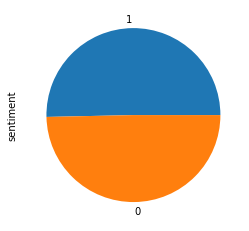

In [7]:
y.value_counts().plot(kind='pie')

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

## 2. Supervised Learning

### 2.1 Logistic Regression

After vectorizing texts, you can use any ML algorithm to build a NLP classifier. But keep in mind that there is a huge number of features in this case.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
import re

In [14]:
def stem_tokenizer(text):
    stemmer = EnglishStemmer(ignore_stopwords=True)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", text).lower().split()
    words = [stemmer.stem(word) for word in words]
    return words 

In [15]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'),
                        tokenizer=stem_tokenizer,
                        lowercase=True,
                        max_df=0.5,
                        min_df=5,
                        ngram_range=(1, 3)
                       )

In [16]:
lgclassifier = Pipeline([('tfidf', tfidf), ('lg', LogisticRegression())])

In [17]:
lgclassifier = lgclassifier.fit(X_train, y_train)

In [18]:
print(classification_report(y_test, lgclassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       716
           1       0.85      0.88      0.86       784

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



**Example**: Get the most important grams

In [25]:
grams = [''] * len(lgclassifier['tfidf'].vocabulary_)
for k, v in lgclassifier['tfidf'].vocabulary_.items():
    grams[v] = k
   

In [20]:
gram_weight = list(zip(grams, lgclassifier['lg'].coef_[0]))
gram_weight.sort(key=lambda x: x[1])

In [21]:
gram_weight[:5]

[('bad', -5.088262361964956),
 ('worst', -3.546877610840104),
 ('wast', -3.0172729746229985),
 ('poor', -2.9718451865933115),
 ('aw', -2.635037401092495)]

In [22]:
gram_weight[-5:]

[('best', 2.059697814633336),
 ('perfect', 2.3233155440390347),
 ('excel', 2.4377771977149068),
 ('love', 3.0990176525314324),
 ('great', 3.9504520717052394)]

### 2.2 Naive Bayes

In [26]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
cv = CountVectorizer(stop_words=stopwords.words('english'),
                     tokenizer=stem_tokenizer,
                     lowercase=True,
                     max_df=0.5,
                     min_df=5,
                     ngram_range=(1, 3),
                     binary=True
                    )

In [28]:
nbclassifier = Pipeline([('cv', cv), ('nb', BernoulliNB())])

In [29]:
nbclassifier = nbclassifier.fit(X_train, y_train)

In [30]:
print(classification_report(y_test, nbclassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       716
           1       0.85      0.87      0.86       784

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



<font color='red'>Question:</font> Why Naive Bayes is Naive?

<font color='red'>Question:</font> What are the pros and cons of Naive Bayes models?

<font color='red'>Question:</font> We use BernoulliNB here. What are the other Naive Bayes models? What are the differences? Why do we need to set "binary=True" in Countvectorizer?

#### If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.

#### When binary = True, we will perform one hot encoding of the given data.

#### When binary = False, we will calculate frequency of the given data.

**Example**: Get the most important grams

In [31]:
nbclassifier['nb'].feature_log_prob_.shape

(2, 14726)

In [32]:
pos_weight = list(zip(grams, nbclassifier['nb'].feature_log_prob_[0]))
pos_weight.sort(key=lambda x: x[1])
pos_weight[-5:]

[('watch', -0.9443808562264415),
 ('good', -0.9313842833992609),
 ('time', -0.925661807125195),
 ('make', -0.9199718913475161),
 ('even', -0.9030938535601649)]

In [38]:
neg_weight = list(zip(grams, nbclassifier['nb'].feature_log_prob_[1]))
neg_weight.sort(key=lambda x: x[1])
neg_weight[-5:]

[('stori', -1.0485878104147925),
 ('make', -1.008292270236784),
 ('see', -0.9695577610556425),
 ('good', -0.9559726464653364),
 ('time', -0.8426975072481424)]

<font color='red'>Question:</font> How **feature_log_prob_** is calculated? Any way to improve it? My solution is in this article (https://www.linkedin.com/pulse/rescale-amazon-ratings-using-reviews-guo-li/).